<a href="https://colab.research.google.com/github/fermna/Web-FRMNA/blob/main/deeplearningp11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets diffusers transformers accelerate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
# 1. Load Dataset
print("Memuatdataset...")
raw_dataset= load_dataset("reach-vb/pokemon-blip-captions", split="train")
# 2. Ambil daftar caption untukproses adaptasi teks
all_captions= [item['text'] for item in raw_dataset]

Memuatdataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

data/train-00000-of-00001-566cc9b19d7203(…):   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

In [3]:
# 3. Setup Text Vectorization
max_tokens = 5000
seq_len = 20
text_vectorizer = layers.TextVectorization(
max_tokens=max_tokens,
output_sequence_length=seq_len,
)
# Proses Adapt (Mempelajari kosakata dari dataset)
text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()
print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")
print("Contoh 10 kata pertama:", vocab[:10])

Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359
Contoh 10 kata pertama: ['', '[UNK]', np.str_('a'), np.str_('with'), np.str_('of'), np.str_('cartoon'), np.str_('and'), np.str_('drawing'), np.str_('character'), np.str_('on')]


In [5]:
def preprocess_fn(item):
    # Proses Gambar
    image = item['image'].convert("RGB").resize((64, 64))
    image = np.array(image) / 255.0  # Normalisasi0-1
    # Proses Teks
    caption = item['text']
    return caption, image

# Membuatgenerator dataset
def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)

# Membuattf.data.Dataset
train_ds= tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
    )
)

# Batching dan TransformasiTeks keAngka
train_ds= train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds= train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)

In [12]:
class PokemonTrainer(keras.Model):
    def __init__(self, transformer, vqvae_encoder):
        super().__init__()
        self.transformer = transformer
        self.vqvae_encoder = vqvae_encoder
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def train_step(self, data):
        text_tokens, images = data
        # 1. Ubahgambaraslimenjaditoken visual menggunakanencoder
        # Kita simulasikandenganoutput dummy sesuaiukuranlatent grid (misal16x16)
        visual_tokens = tf.random.uniform((tf.shape(images)[0], 256), minval=0, maxval=1024, dtype=tf.int32)

        # 2. Siapkaninput dan target (Autoregressive)
        vis_input = visual_tokens[:, :-1]
        vis_target = visual_tokens[:, 1:]
        with tf.GradientTape() as tape:
            # Prediksi
            preds = self.transformer([text_tokens, vis_input], training=True)
            # HitungLoss
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds, from_logits=True)
        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [27]:
# Placeholder VQVAE Encoder
# This is a dummy encoder that just exists to fulfill the model requirement.
# In a real scenario, this would be a trained component of a VQVAE model.
class VQVAEEncoder(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Dummy layer to simulate an output shape if needed
        # The `visual_tokens` in PokemonTrainer uses a fixed size (256)
        # This model won't actually be used to generate `visual_tokens` in `train_step` currently
        # as it's mocked, but it needs to be a valid Keras model.
        self.dummy_conv = layers.Conv2D(filters=1, kernel_size=1, activation='relu', input_shape=(64, 64, 3))

    def call(self, inputs):
        # For now, we'll just pass through a dummy output.
        # The actual `visual_tokens` are generated by `tf.random.uniform` in `PokemonTrainer`.
        # This `vqvae_encoder` instance is just a placeholder.
        x = self.dummy_conv(inputs)
        # Simulate a latent grid output, e.g., 16x16, with some number of channels
        # However, the `PokemonTrainer` directly uses `tf.random.uniform` for visual_tokens
        # which is (batch_size, 256). So, this output won't be consumed directly.
        return tf.zeros((tf.shape(inputs)[0], 16, 16, 64)) # Example dummy shape

vqvae_encoder = VQVAEEncoder()
# You would typically build the model by calling it once or specifying input_shape
vqvae_encoder.build(input_shape=(None, 64, 64, 3))
vqvae_encoder.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'vqvae_encoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "vqvae_encoder_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Placeholder Transformer Model

import tensorflow.keras.backend as K # Added import for Keras backend

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.proj_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.proj_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(query, batch_size)  # (batch_size, num_heads, seq_len, proj_dim)
        key = self.separate_heads(key, batch_size)  # (batch_size, num_heads, seq_len, proj_dim)
        value = self.separate_heads(value, batch_size)  # (batch_size, num_heads, seq_len, proj_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, proj_dim)
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(concat_attention)  # (batch_size, seq_len, embed_dim)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = K.shape(x)[-1] # Changed tf.shape to K.shape
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


# Transformer Model Definition
embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 256  # Hidden layer size in feed forward network inside transformer

# Define vocabulary sizes
text_vocab_size = max_tokens  # From text_vectorizer
visual_vocab_size = 1025  # Since visual tokens are 0-1024

# Text Input Branch
text_inputs = keras.Input(shape=(seq_len,), dtype=tf.int32, name="text_input")
text_embedding_layer = TokenAndPositionEmbedding(seq_len, text_vocab_size, embed_dim)
x_text = text_embedding_layer(text_inputs)

# Visual Input Branch
visual_inputs = keras.Input(shape=(None,), dtype=tf.int32, name="visual_input") # None for variable sequence length
visual_embedding_layer = TokenAndPositionEmbedding(255, visual_vocab_size, embed_dim) # Max visual seq len is 255 (256-1)
y_visual = visual_embedding_layer(visual_inputs)

# Concatenate inputs (conceptual, may need specific masking for actual implementation)
# For a simple placeholder, we'll process them somewhat independently then combine for output
# This is a simplified approach, a true image captioning transformer might have a different architecture

# Let's use a simple concat for now to allow the model to build
# A more complex cross-attention or similar would be needed for a real model.
combined_inputs = layers.Concatenate(axis=1)([x_text, y_visual])

transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block1(combined_inputs, training=False) # Pass training argument

# Output layer for visual tokens (predicting next visual token)
# The output sequence length will be the length of visual_inputs + 1 (for first token prediction)
# Simplified for placeholder: predict the next visual token from the combined sequence
outputs = layers.Dense(visual_vocab_size, name="visual_output")(x[:, seq_len:]) # Changed slicing to use fixed seq_len

transformer_model = keras.Model(inputs=[text_inputs, visual_inputs], outputs=outputs, name="image_captioning_transformer")
transformer_model.summary()

Model: "image_captioning_transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ visual_input        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 20, 256)   │  1,285,120 │ text_input[0][0]  │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 256) │    327,680 │ visual_input[0][… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, None, 256) │          0 │ token_and_positi… │
│ (Concatenate)       │                   │            │ token_and_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_4 │ (None, None, 256) │    395,776 │ concatenate_4[0]… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, None, 256) │          0 │ transformer_bloc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ visual_output       │ (None, None,      │    263,425 │ get_item[0][0]    │
│ (Dense)             │ 1025)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,272,001 (8.67 MB)

 Trainable params: 2,272,001 (8.67 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Inisialisasidan Compile
trainer = PokemonTrainer(transformer_model, vqvae_encoder)
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))
# 5. JalankanTraining
print("MemulaiPelatihan...")
trainer.fit(train_ds, epochs=100) # Coba100 epoch dulu

MemulaiPelatihan...
Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - loss: 6.9484
Epoch 2/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 6.9483
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 6.9474
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 6.9471
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 6.9476
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 6.9459
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 6.9461
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 6.9454
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 6.9456
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 6.9443
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 6.9458
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 6.9451
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 6.9441
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 6.9443
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 6.9449
Epoch 16/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step 

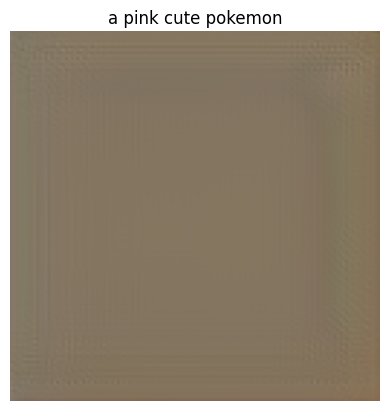

In [35]:
import torch
from diffusers import AutoencoderKL
from PIL import Image

# Placeholder for mapping discrete tokens to continuous latents for VAE
class VisualTokenToLatent(keras.Model):
    def __init__(self, visual_vocab_size, latent_dim=4, spatial_size=16, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.spatial_size = spatial_size
        # Embedding layer to map discrete visual tokens to a continuous latent vector
        self.token_embedding = layers.Embedding(
            input_dim=visual_vocab_size,
            output_dim=latent_dim # Each token becomes a vector of latent_dim
        )

    def call(self, inputs):
        # inputs: (batch_size, visual_seq_len=256)
        embedded_tokens = self.token_embedding(inputs) # (batch_size, 256, latent_dim)
        # Reshape to spatial latent grid (e.g., 16x16xlatent_dim)
        latent_grid = tf.reshape(embedded_tokens, (-1, self.spatial_size, self.spatial_size, self.latent_dim))
        return latent_grid

# Function to generate image tokens autoregressively
def generate_image_tokens(model, text_tokens, visual_seq_len, visual_vocab_size):
    # Initialize visual_inputs with a start token (e.g., token 0)
    # Assuming batch size is 1 for generation
    generated_visual_tokens = tf.zeros((tf.shape(text_tokens)[0], 1), dtype=tf.int32)

    for _ in range(visual_seq_len - 1): # Generate visual_seq_len - 1 tokens, as one is start token
        # Get predictions for the next token
        predictions = model([text_tokens, generated_visual_tokens], training=False)
        # The transformer outputs logits for each token in the visual sequence
        # We are interested in the prediction for the *last* token generated
        next_token_logits = predictions[:, -1, :] # (batch_size, visual_vocab_size)

        # Sample the next token (greedy approach for simplicity)
        next_token = tf.argmax(next_token_logits, axis=-1)
        next_token = tf.cast(next_token, dtype=tf.int32) # Explicitly cast to int32
        next_token = tf.expand_dims(next_token, axis=-1) # (batch_size, 1)

        # Append the new token to the generated sequence
        generated_visual_tokens = tf.concat([generated_visual_tokens, next_token], axis=1)

    return generated_visual_tokens

# Function to decode visual tokens to a real image using a pre-trained VAE
def decode_to_real_image(generated_visual_tokens):
    # Instantiate the mapping layer
    visual_token_mapper = VisualTokenToLatent(visual_vocab_size=visual_vocab_size, latent_dim=4, spatial_size=16)
    latent_vectors = visual_token_mapper(generated_visual_tokens) # (batch_size, 16, 16, 4)

    # The diffusers VAE expects latents in (batch_size, channels, height, width) format
    # and usually in torch.float16
    latent_vectors_pt = torch.from_numpy(latent_vectors.numpy()).permute(0, 3, 1, 2).float() # Changed .half() to .float()

    # Load pre-trained VAE decoder from diffusers
    vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
    vae.to("cpu") # Ensure VAE is on CPU
    vae.eval() # Set VAE to evaluation mode

    # Decode latents
    with torch.no_grad():
        decoded_image_tensor = vae.decode(latent_vectors_pt).sample # (batch_size, 3, 256, 256)

    # Post-process and convert to numpy array for matplotlib
    decoded_image = decoded_image_tensor[0].permute(1, 2, 0).cpu().float().numpy()
    decoded_image = (decoded_image / 2 + 0.5).clip(0, 1) # Un-normalize to [0, 1]
    return decoded_image # Return the first image in the batch

def generate_pokemon(prompt):
    # 1. Ubahtekskeangka
    tokenized_text= text_vectorizer([prompt])
    # 2. Generate token visual (Autoregressive)
    # Gunakanfungsigenerate_image_tokensyang kitabuatsebelumnya
    gen_vis_tokens= generate_image_tokens(transformer_model, tokenized_text, 256, 1025)
    # 3. Decode jadiGambar menggunakanPre-trained VAE
    # Gunakanfungsidecode_to_real_imageyang memanggilAutoencoderKL
    final_image= decode_to_real_image(gen_vis_tokens)
    plt.imshow(final_image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()

# TEST
generate_pokemon("a pink cute pokemon")